# Finer Granularity for more Precision
In this notebook I have tested quantization methods with different granularities.
- `Per Tensor`
- `Per Channel`
- `Per Group`

For symplicity I have used symmetric mode for quantization

In [ ]:
import torch
from helper import plot_quantization_errors, Calc_MSE, get_q_scale_symmetric, linear_q_with_s_and_z, linear_dq_with_s_and_z

In [ ]:
test_tensor=torch.tensor(
    [[191.6, -13.5, 728.6],
     [92.14, 295.5,  -184],
     [0,     684.6, 245.5]]
)

## 1. Per Tensor
`Per Tensor` quantization applies the same scale and zero-point values across the entire tensor. This method simplifies computations and reduces storage overhead but can lead to lower accuracy, particularly if the tensor's values have a wide range.

In [ ]:
from helper import linear_quantization_symm,linear_dequantization_symm

In [ ]:
quantized_tensor,s = linear_quantization_symm(test_tensor)
dequantized_tensor = linear_dequantization_symm(quantized_tensor,s)
print ("Scale =",s)

Scale = 5.737007681779035


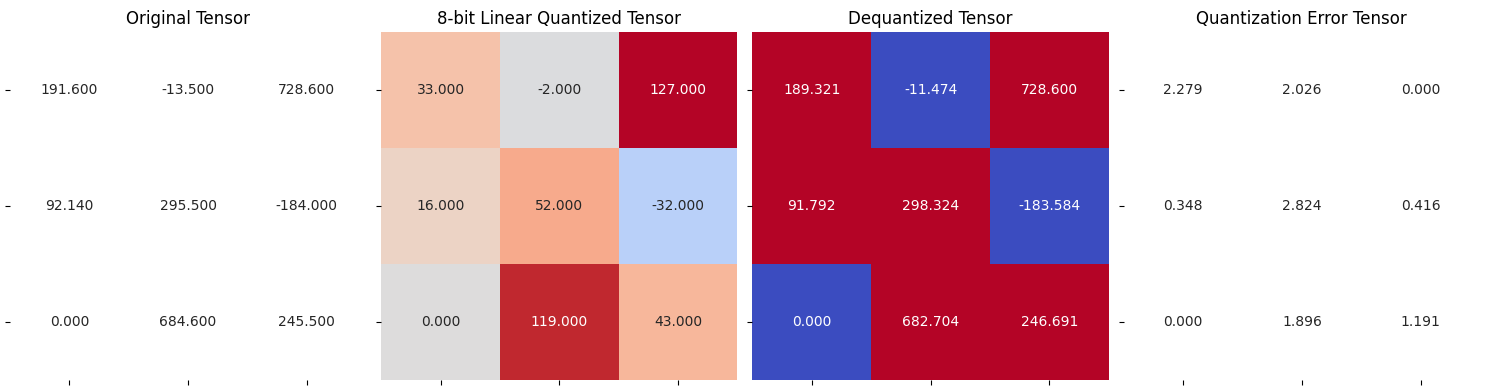

In [ ]:
plot_quantization_errors(test_tensor,quantized_tensor,dequantized_tensor)

In [ ]:
MSE = Calc_MSE(test_tensor,dequantized_tensor)
print (MSE)

tensor(2.5092)


## 2. Per Channel
`Per Channel` quantization uses different scale and zero-point values for each channel (e.g., each filter in a convolutional layer). This approach captures variations within each channel, often resulting in better model accuracy compared to per tensor quantization while maintaining efficient computation.

In [ ]:
def linear_quantization_symm_per_channel(tensor,dim):
    output_dim = tensor.shape[dim]
    scales = torch.zeros(output_dim)
    for i in range(output_dim):
        sub_tensor = tensor.select(dim,i)
        scales[i] = get_q_scale_symmetric(sub_tensor)
    shape = [1]*tensor.dim()
    shape[dim] = -1
    reshaped_scales = scales.reshape(shape)
    quantized_tensor = linear_q_with_s_and_z(tensor,reshaped_scales,0)
    return quantized_tensor, reshaped_scales

def linear_dequantization_symm_per_channel(tensor, scales):
    dequantized_tensor = linear_dequantization_symm(tensor,scales)
    return dequantized_tensor

In [ ]:
quantized_tensor, scales = linear_quantization_symm_per_channel(test_tensor,dim = 0)
dequantized_tensor = linear_dequantization_symm_per_channel(quantized_tensor,scales)
print ("Scales =",scales)

Scales = tensor([[5.7370],
        [2.3268],
        [5.3906]])


In [ ]:
print (quantized_tensor)

tensor([[ 33,  -2, 127],
        [ 40, 127, -79],
        [  0, 127,  46]], dtype=torch.int8)


In [ ]:
print (dequantized_tensor)

tensor([[ 189.3213,  -11.4740,  728.6000],
        [  93.0709,  295.5000, -183.8150],
        [   0.0000,  684.6000,  247.9653]])


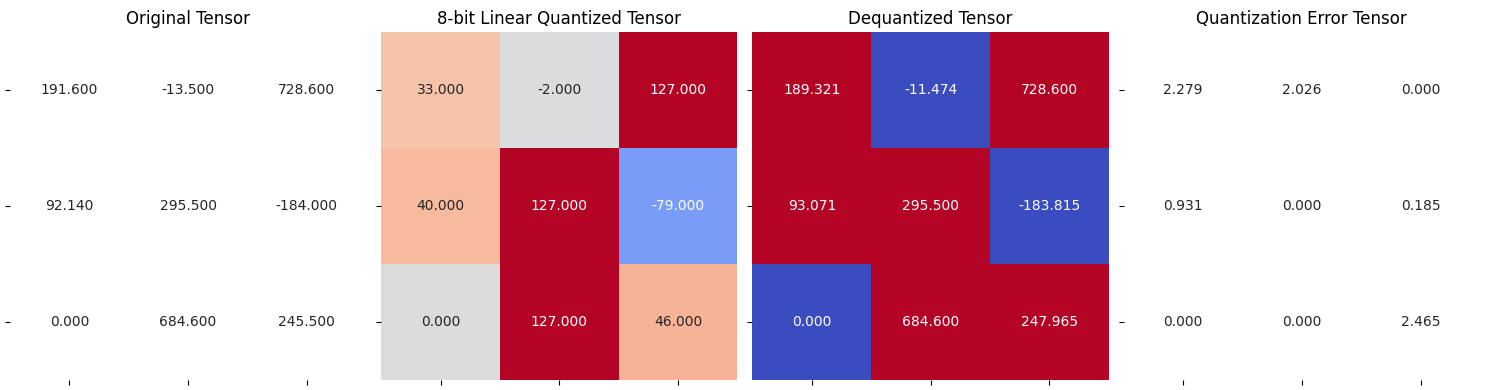

In [ ]:
plot_quantization_errors(test_tensor,quantized_tensor,dequantized_tensor)

In [ ]:
MSE = Calc_MSE(test_tensor,dequantized_tensor)
print (MSE)

tensor(1.8084)


## 3. Per Group
`Per Group` quantization divides the tensor into smaller groups and applies different scale and zero-point values to each group. This technique balances between per tensor and per channel quantization, offering improved accuracy by adapting to variations within groups while keeping the computational complexity lower than per channel quantization.

For simplicity I have quantized 2D tensors along the rows.

In [ ]:
test_tensor = torch.rand(6,6)
print (test_tensor)

tensor([[0.3428, 0.4323, 0.2692, 0.5690, 0.6206, 0.6081],
        [0.3806, 0.0288, 0.3622, 0.5770, 0.0778, 0.3194],
        [0.1440, 0.7671, 0.6961, 0.9664, 0.7623, 0.1735],
        [0.4996, 0.4777, 0.8860, 0.8599, 0.5519, 0.6200],
        [0.0537, 0.0561, 0.7333, 0.9506, 0.7293, 0.4973],
        [0.0035, 0.5029, 0.2044, 0.9070, 0.4680, 0.2224]])


In [ ]:
def linear_quantization_symm_per_group(tensor, group_size, dimension):
    tensor_shape = tensor.shape
    assert (tensor.shape[0]*tensor.shape[1])%group_size == 0
    assert tensor.dim() == 2
    tensor.reshape(-1,group_size)
    quantized_tensor, scales = linear_quantization_symm_per_channel(tensor,dimension)
    quantized_tensor.reshape(tensor_shape)
    return quantized_tensor, scales


def linear_dequantization_symm_per_group(tensor,scales, group_size, dimension):
    tensor_shape = tensor.shape
    tensor.reshape(-1,group_size)
    dequantized_tensor = linear_dequantization_symm_per_channel(tensor,scales)
    dequantized_tensor.reshape(tensor_shape)
    return dequantized_tensor

In [ ]:
dim = 0
group_size = 3
quantized_tensor, scales = linear_quantization_symm_per_group(test_tensor, group_size, dim)
dequantized_tensor = linear_dequantization_symm_per_group(quantized_tensor, scales, group_size, dim)
print ("Scales =",scales)

Scales = tensor([[0.0049],
        [0.0045],
        [0.0076],
        [0.0070],
        [0.0075],
        [0.0071]])


In [ ]:
print (quantized_tensor)

tensor([[ 70,  88,  55, 116, 127, 124],
        [ 84,   6,  80, 127,  17,  70],
        [ 19, 101,  91, 127, 100,  23],
        [ 72,  68, 127, 123,  79,  89],
        [  7,   7,  98, 127,  97,  66],
        [  0,  70,  29, 127,  66,  31]], dtype=torch.int8)


In [ ]:
print (dequantized_tensor)

tensor([[0.3421, 0.4300, 0.2688, 0.5668, 0.6206, 0.6059],
        [0.3816, 0.0273, 0.3635, 0.5770, 0.0772, 0.3180],
        [0.1446, 0.7685, 0.6924, 0.9664, 0.7609, 0.1750],
        [0.5023, 0.4744, 0.8860, 0.8581, 0.5511, 0.6209],
        [0.0524, 0.0524, 0.7336, 0.9506, 0.7261, 0.4940],
        [0.0000, 0.4999, 0.2071, 0.9070, 0.4713, 0.2214]])


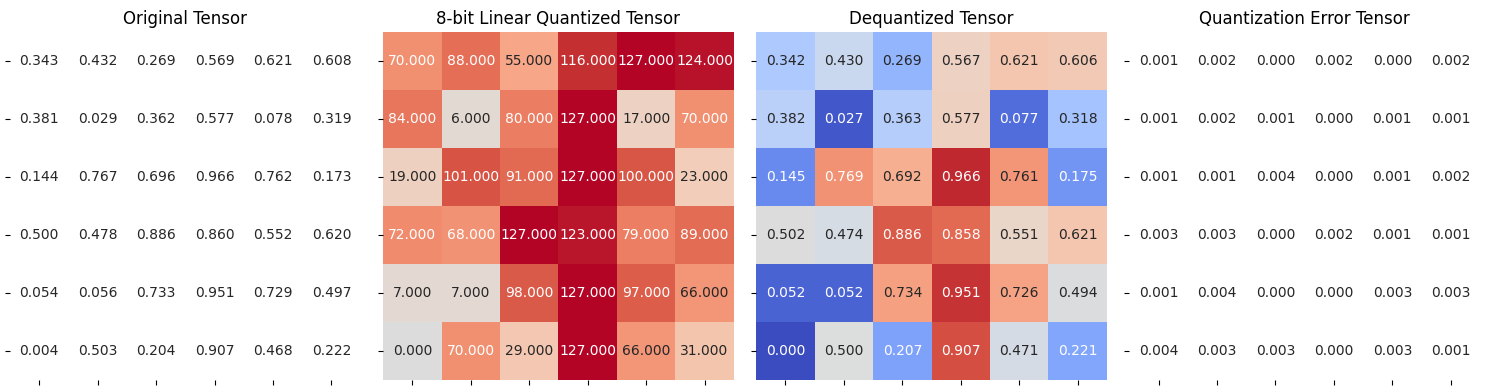

In [ ]:
plot_quantization_errors(test_tensor,quantized_tensor, dequantized_tensor)

In [ ]:
MSE = Calc_MSE(test_tensor,dequantized_tensor)
print (MSE)

tensor(3.9955e-06)
